In [1]:
cd ../..

/disk1/home/svo6059/masters/spikelearn


# Env 

## Imports 

In [25]:
from spikelearn.data import frankenstein, io, SHORTCUTS
from pickle import load
import pandas as pd

In [162]:
from src.models.makeRegressorList import makeRegressorList
from src.models.makeClassifierList import makeClassifierList

In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics.scorer import explained_variance_scorer
from sklearn.preprocessing import RobustScaler

## Functions 

# Data Loading 

In [64]:
# Merging rats
DR = [io.load(label, 'wide_smoothed') for label in SHORTCUTS['groups']['DRRD']]
EZ = [io.load(label, 'wide_smoothed') for label in SHORTCUTS['groups']['EZ']]

sp_pfc = frankenstein(DR, _min_duration=1.5, is_selected=True, is_tired=False).reset_index()
                                                    

ez_pfc = frankenstein(EZ, _min_duration=1.5, _min_quality=0, area='PFC').reset_index().groupby('trial')\
                                                    .filter(lambda df: df.trial.values[0]%2==1).set_index(['trial','time'])

ez_str = frankenstein(EZ, _min_duration=1.5, _min_quality=0, area='STR').reset_index().groupby('trial')\
                                                    .filter(lambda df: df.trial.values[0]%2==1).set_index(['trial','time'])
merged_rats = [sp_pfc, ez_pfc, ez_str]

In [163]:
regressors = makeRegressorList()
classifiers = makeClassifierList()

In [80]:
import numpy as np

In [165]:
best_params_reg = load(open('data/results/regression_hyperopt/best_params_of_all.csv','rb'))
best_params_clf = load(open('data/results/holdout_hyperopt/best_params_of_all.csv','rb'))
def best_params(clf_name, rat, which='reg'):
    if which=='reg':
        D = best_params_reg
    else:
        D = best_params_clf
    
    if clf_name in D.reset_index().clf.values:
        p =  dict(D.loc[clf_name, rat].dropna())
        for ipar in ['n_estimators', 'n_neighbors', 'max_depth', 'hidden_layer_sizes', 'num_leaves']:
            if ipar in p:
                p[ipar] = int(p[ipar])
        return p
    else:
        return None

# Calculate performance on unseen data 

## Regression 

In [67]:
df_train = df.groupby('trial').filter(lambda df: df.trial.values[0]%2==1).set_index(['trial','time'])
df_test = df.groupby('trial').filter(lambda df: df.trial.values[0]%2==0).set_index(['trial','time'])

In [98]:
rat_label, df = 'sp_pfc', sp_pfc
results = {}
for regressor in regressors:
    clf = regressor['func']
    print(regressor['name'])
    
    # Tuned
    pars = best_params(regressor['name'], rat_label)
    if pars is not None:
        clf = make_pipeline(RobustScaler(), regressor['func'](**pars))
        clf.fit(df_train.values, df_train.reset_index().time)
        res = explained_variance_scorer(clf, df_test.values, df_test.reset_index().time)
        results[('tuned', regressor['name'])] = res
    
    # Untuned
    clf = make_pipeline(RobustScaler(), regressor['func']())
    clf.fit(df_train.values, df_train.reset_index().time)
    res = explained_variance_scorer(clf, df_test.values, df_test.reset_index().time)
    results[('untuned', regressor['name'])] = res

knn
linSVM


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


rbfSVM


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


ElasticNet


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Decision_tree
Random_forest


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Neural_network


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


XGboost
LightGBM
CatBoost
BayesianRidge
ARD


In [122]:
R = pd.Series(results).T.reset_index()
R.columns = ['is_tuned', 'model', 'explained variance']

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

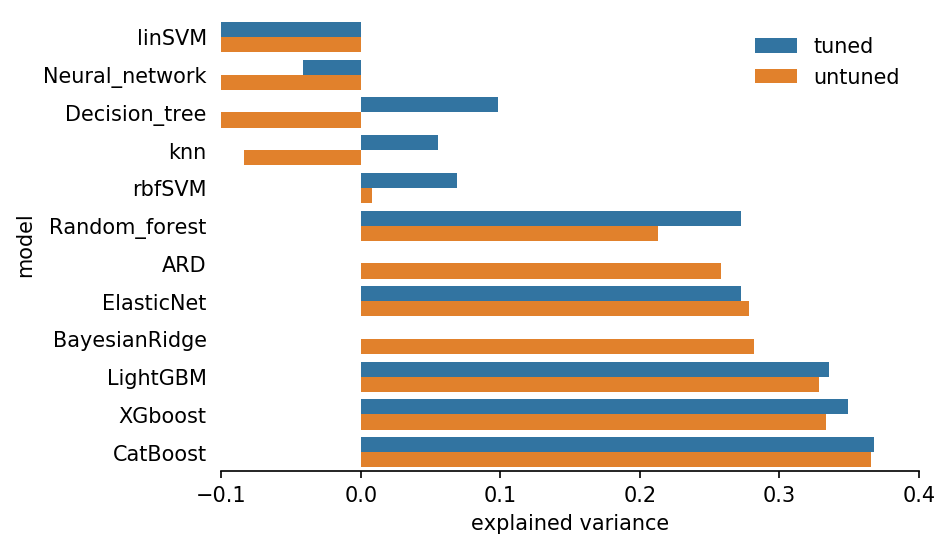

In [161]:
plt.figure(dpi=150)
order = R.groupby('model')['explained variance'].mean().sort_values().index.values
sns.barplot('explained variance', 'model',  'is_tuned', R, order=order)
plt.xlim(-.1,.4)
plt.legend(title=False, frameon=False)
sns.despine(left=True)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False)

# plt.grid(axis='x')

## Classification 

In [67]:
df_train = df.groupby('trial').filter(lambda df: df.trial.values[0]%2==1).set_index(['trial','time'])
df_test = df.groupby('trial').filter(lambda df: df.trial.values[0]%2==0).set_index(['trial','time'])

In [174]:
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

make_scorer(pearsonr)

In [182]:
rat_label, df = 'sp_pfc', sp_pfc
results = {}
for classifier in classifiers:
    clf = classifier['func']
    print(classifier['name'])
    
    # Tuned
    pars = best_params(classifier['name'], rat_label, 'clf')
    if pars is not None:
        clf = make_pipeline(RobustScaler(), classifier['func'](**pars))
        clf.fit(df_train.values, df_train.reset_index().time)
        res = make_scorer(pearsonr)(clf, df_test.values, df_test.reset_index().time)[0]
        results[('tuned', classifier['name'])] = res
    
    # Untuned
    clf = make_pipeline(RobustScaler(), classifier['func']())
    clf.fit(df_train.values, df_train.reset_index().time)
    res = make_scorer(pearsonr)(clf, df_test.values, df_test.reset_index().time)[0]
    results[('untuned', classifier['name'])] = res

knn
linSVM


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


rbfSVM


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Decision_tree
Random_forest


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Neural_network
Naive_bayes
QDA
LDA
Logistic_Regression


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/disk1/hom

XGboost
LightGBM


In [183]:
R = pd.Series(results).T.reset_index()
R.columns = ['is_tuned', 'model', "pearson's r"]

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

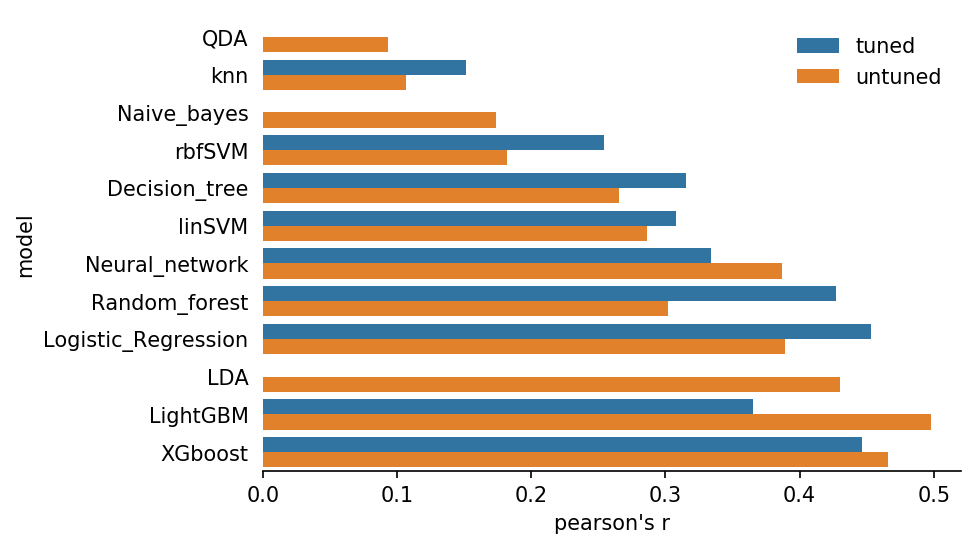

In [190]:
plt.figure(dpi=150)
order = R.groupby('model')["pearson's r"].mean().sort_values().index.values
sns.barplot("pearson's r", 'model',  'is_tuned', R, order=order)
plt.xlim(0,.52)
plt.legend(title=False, frameon=False, loc='upper right')
sns.despine(left=True)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False)